# Notebook for evaluating the trained models

In [18]:
# Library imports
from tqdm import tqdm
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sb

In [19]:
# Allow imports from the src directory
import sys
import os
from pathlib import Path
path_src_dir = os.path.join(str(Path(os.path.dirname(os.path.abspath(os.path.abspath('')))).parents[0]), 'hivefive', 'src')
path_modeling_dir = os.path.join(path_src_dir, 'modeling')
sys.path.append(path_src_dir)
sys.path.append(path_modeling_dir)

In [20]:
# Import of local files
import config
from train import Train
from train_kaggle import TrainKaggle
from model import CNNModel
from yamnet import YamnetTransferModel
import model_evaluation

In [21]:
metadata = np.load(config.PROCESSED_METADATA_FILE_SEGMENTED, allow_pickle=True)

metadata_column_names = ['sample_name', "label", "hive_number", "segment",]
metadata_df = pd.DataFrame(metadata, columns=metadata_column_names)

metadata_df.head()

,sample_name,label,hive_number,segment
0,Hive1 12_06_2018_QueenBee____00_00_00,0,1,Hive1 12_06_2018_QueenBee____00_00_00__segment0
1,Hive1 12_06_2018_QueenBee____00_00_00,0,1,Hive1 12_06_2018_QueenBee____00_00_00__segment1
2,Hive1 12_06_2018_QueenBee____00_00_00,0,1,Hive1 12_06_2018_QueenBee____00_00_00__segment2
3,Hive1 12_06_2018_QueenBee____00_00_00,0,1,Hive1 12_06_2018_QueenBee____00_00_00__segment3
4,Hive1 12_06_2018_QueenBee____00_00_00,0,1,Hive1 12_06_2018_QueenBee____00_00_00__segment4


## Evaluate CNN which was trained on all data

In [7]:
model_name = 'model_20240923_131940_19_all_data'

trainer = Train(CNNModel(), nn.BCELoss())
checkpoint_path = '../models/final/' + model_name + '_checkpoint.pt'
model = CNNModel()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
model_loaded, optimizer, start_epoch, train_samples, val_samples, test_samples = trainer.load_model(checkpoint_path, model, optimizer)
model = model_loaded

Layer (type:depth-idx)                   Param #
CNNModel                                 --
├─Conv2d: 1-1                            160
├─Conv2d: 1-2                            4,640
├─Conv2d: 1-3                            18,496
├─Conv2d: 1-4                            73,856
├─MaxPool2d: 1-5                         --
├─Flatten: 1-6                           --
├─Linear: 1-7                            1,130,560
├─Linear: 1-8                            65
Total params: 1,227,777
Trainable params: 1,227,777
Non-trainable params: 0


In [ ]:
torch.onnx.export(model, next(iter(trainer.training_dataloader))[0], model_name + "_CNN.onnx", input_names=["MEL-Spectrograms"], output_names=["predictions"])

In [8]:
model.eval()

labels_test = []
predictions_test = []

with torch.no_grad():
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Evaluation will happen on {device}.")
    model.to(device)

    for vdata in tqdm(trainer.test_dataloader):
        vinputs, vlabels = vdata
        vinputs, vlabels = vinputs.to(device), vlabels.to(device)
        voutputs = model(vinputs)
        labels_test.extend(vlabels)
        predictions_test.extend(voutputs)

labels_test = torch.stack(labels_test)
predictions_test = torch.stack(predictions_test)

print(labels_test.shape)

Evaluation will happen on cpu.


100%|██████████| 27/27 [00:45<00:00,  1.69s/it]

torch.Size([860])


### Plot confusion matrix

<Axes: title={'center': 'Confusion Matrix: Trainiertes CNN auf allen Daten'}, xlabel='Predicted', ylabel='Actual'>

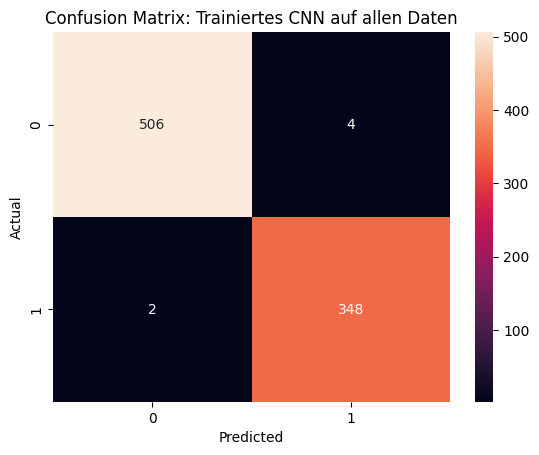

In [9]:
conf_matr = confusion_matrix(labels_test.cpu().numpy(), predictions_test.cpu().numpy().squeeze().round())
plt = sb.heatmap(conf_matr, annot=True, fmt='d')
plt.set_xlabel("Predicted")
plt.set_ylabel("Actual")
plt.set_title("Confusion Matrix: Trainiertes CNN auf allen Daten")
plt

### Print classification report

In [10]:
print(classification_report(labels_test.cpu().numpy(), predictions_test.cpu().numpy().squeeze().round()))

              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99       510
         1.0       0.99      0.99      0.99       350

    accuracy                           0.99       860
   macro avg       0.99      0.99      0.99       860
weighted avg       0.99      0.99      0.99       860



### Plot ROC-Curve

In [11]:
predictions_test_array = predictions_test[:, np.newaxis]
labels_test_array = labels_test[:, np.newaxis]

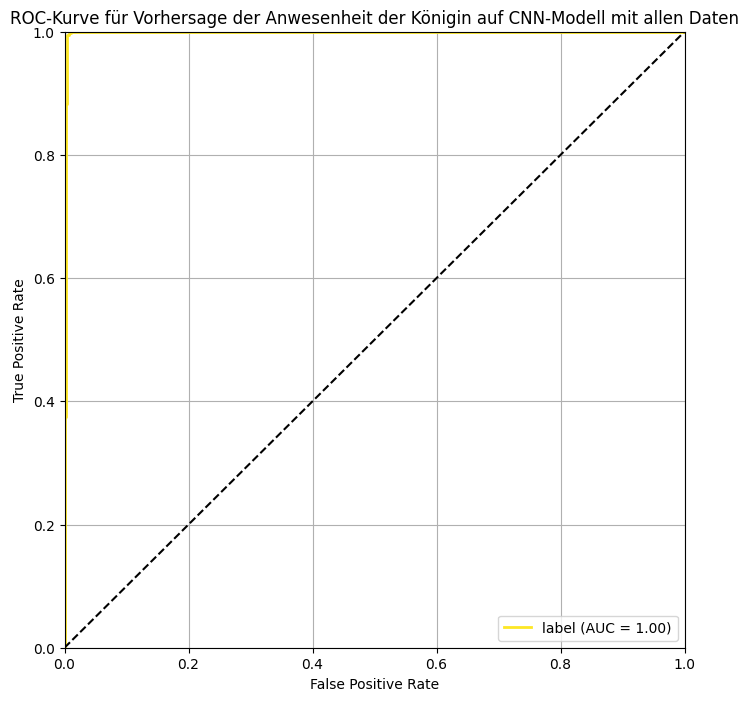

In [12]:
model_evaluation.plot_roc_curves(labels_test_array, predictions_test_array, classes=["label"], title="ROC-Kurve für Vorhersage der Anwesenheit der Königin auf CNN-Modell mit allen Daten")

## Evaluate hive-Independent CNN (Training-Hive 1, Test-Hive 3)

In [13]:
trainer_hive_independent = Train(CNNModel(), nn.BCELoss(), training_hive=1)

Layer (type:depth-idx)                   Param #
CNNModel                                 --
├─Conv2d: 1-1                            160
├─Conv2d: 1-2                            4,640
├─Conv2d: 1-3                            18,496
├─Conv2d: 1-4                            73,856
├─MaxPool2d: 1-5                         --
├─Flatten: 1-6                           --
├─Linear: 1-7                            1,130,560
├─Linear: 1-8                            65
Total params: 1,227,777
Trainable params: 1,227,777
Non-trainable params: 0


In [14]:
model_name = 'model_20240923_155143_18_training_hive1'

checkpoint_path = '../models/final/' + model_name + '_checkpoint.pt'
model = CNNModel()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
model_loaded, optimizer, start_epoch, train_samples, val_samples, test_samples = trainer_hive_independent.load_model(checkpoint_path, model, optimizer)
model = model_loaded

In [15]:
model.eval()

labels_test = []
predictions_test = []

with torch.no_grad():
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Evaluation will happen on {device}.")
    model.to(device)

    for vdata in tqdm(trainer_hive_independent.test_dataloader):
        vinputs, vlabels = vdata
        vinputs, vlabels = vinputs.to(device), vlabels.to(device)
        voutputs = model(vinputs)
        labels_test.extend(vlabels)
        predictions_test.extend(voutputs)

labels_test = torch.stack(labels_test)
predictions_test = torch.stack(predictions_test)

print(labels_test.shape)

Evaluation will happen on cpu.


100%|██████████| 90/90 [02:28<00:00,  1.65s/it]

torch.Size([2857])


### Plot confusion matrix

<Axes: title={'center': 'Confusion Matrix: Trainiertes CNN auf Daten des Bienenstocks 1'}, xlabel='Predicted', ylabel='Actual'>

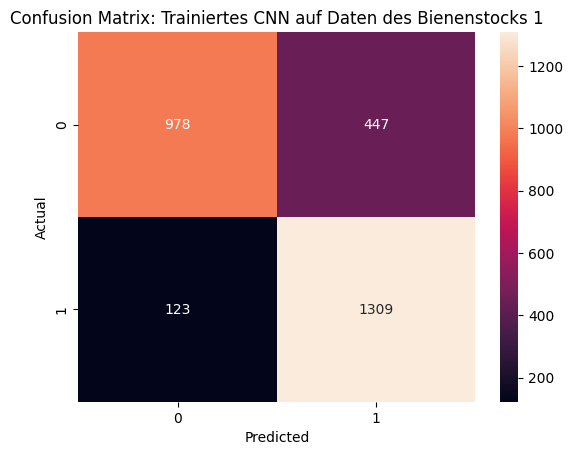

In [16]:
conf_matr = confusion_matrix(labels_test.cpu().numpy(), predictions_test.cpu().numpy().squeeze().round())
plt = sb.heatmap(conf_matr, annot=True, fmt='d')
plt.set_xlabel("Predicted")
plt.set_ylabel("Actual")
plt.set_title("Confusion Matrix: Trainiertes CNN auf Daten des Bienenstocks 1")
plt

### Print classification report

In [17]:
print(classification_report(labels_test.cpu().numpy(), predictions_test.cpu().numpy().squeeze().round()))

              precision    recall  f1-score   support

         0.0       0.89      0.69      0.77      1425
         1.0       0.75      0.91      0.82      1432

    accuracy                           0.80      2857
   macro avg       0.82      0.80      0.80      2857
weighted avg       0.82      0.80      0.80      2857



### Plot ROC-Curve

In [18]:
predictions_test_array = predictions_test[:, np.newaxis]
labels_test_array = labels_test[:, np.newaxis]

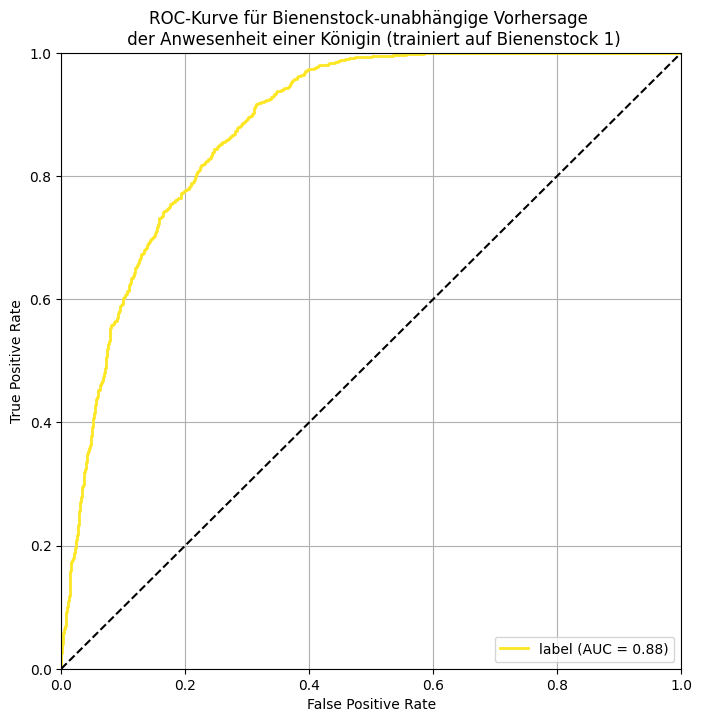

In [19]:
model_evaluation.plot_roc_curves(labels_test_array, predictions_test_array, classes=["label"], title="ROC-Kurve für Bienenstock-unabhängige Vorhersage \n der Anwesenheit einer Königin (trainiert auf Bienenstock 1)")

## Evaluate hive-Independent CNN (Training-Hive 3, Test-Hive 1)

In [20]:
trainer_hive_independent = Train(CNNModel(), nn.BCELoss(), training_hive=3)

Layer (type:depth-idx)                   Param #
CNNModel                                 --
├─Conv2d: 1-1                            160
├─Conv2d: 1-2                            4,640
├─Conv2d: 1-3                            18,496
├─Conv2d: 1-4                            73,856
├─MaxPool2d: 1-5                         --
├─Flatten: 1-6                           --
├─Linear: 1-7                            1,130,560
├─Linear: 1-8                            65
Total params: 1,227,777
Trainable params: 1,227,777
Non-trainable params: 0


In [21]:
model_name = 'model_20240923_171634_19_training_hive3'

checkpoint_path = '../models/final/' + model_name + '_checkpoint.pt'
model = CNNModel()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
model_loaded, optimizer, start_epoch, train_samples, val_samples, test_samples = trainer_hive_independent.load_model(checkpoint_path, model, optimizer)
model = model_loaded

In [23]:
model.eval()

labels_test = []
predictions_test = []

with torch.no_grad():
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Evaluation will happen on {device}.")
    model.to(device)

    for vdata in tqdm(trainer_hive_independent.test_dataloader):
        vinputs, vlabels = vdata
        vinputs, vlabels = vinputs.to(device), vlabels.to(device)
        voutputs = model(vinputs)
        labels_test.extend(vlabels)
        predictions_test.extend(voutputs)

labels_test = torch.stack(labels_test)
predictions_test = torch.stack(predictions_test)

print(labels_test.shape)

Evaluation will happen on cpu.


100%|██████████| 89/89 [02:28<00:00,  1.67s/it]

torch.Size([2832])


### Plot confusion matrix

<Axes: title={'center': 'Confusion Matrix: Trainiertes CNN auf Daten des Bienenstocks 3'}, xlabel='Predicted', ylabel='Actual'>

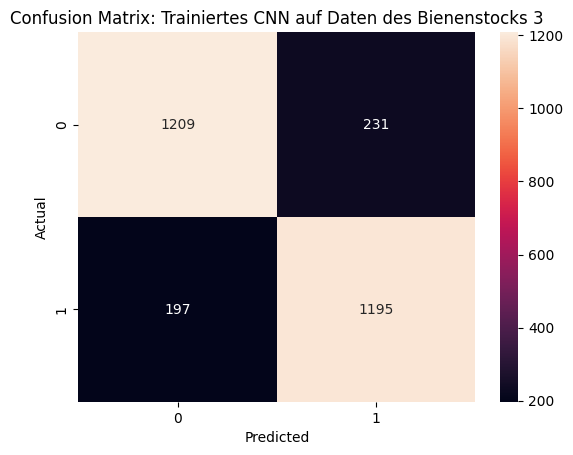

In [24]:
conf_matr = confusion_matrix(labels_test.cpu().numpy(), predictions_test.cpu().numpy().squeeze().round())
plt = sb.heatmap(conf_matr, annot=True, fmt='d')
plt.set_xlabel("Predicted")
plt.set_ylabel("Actual")
plt.set_title("Confusion Matrix: Trainiertes CNN auf Daten des Bienenstocks 3")
plt

### Print classification report

In [25]:
print(classification_report(labels_test.cpu().numpy(), predictions_test.cpu().numpy().squeeze().round()))

              precision    recall  f1-score   support

         0.0       0.86      0.84      0.85      1440
         1.0       0.84      0.86      0.85      1392

    accuracy                           0.85      2832
   macro avg       0.85      0.85      0.85      2832
weighted avg       0.85      0.85      0.85      2832



### Plot ROC-Curve

In [26]:
predictions_test_array = predictions_test[:, np.newaxis]
labels_test_array = labels_test[:, np.newaxis]

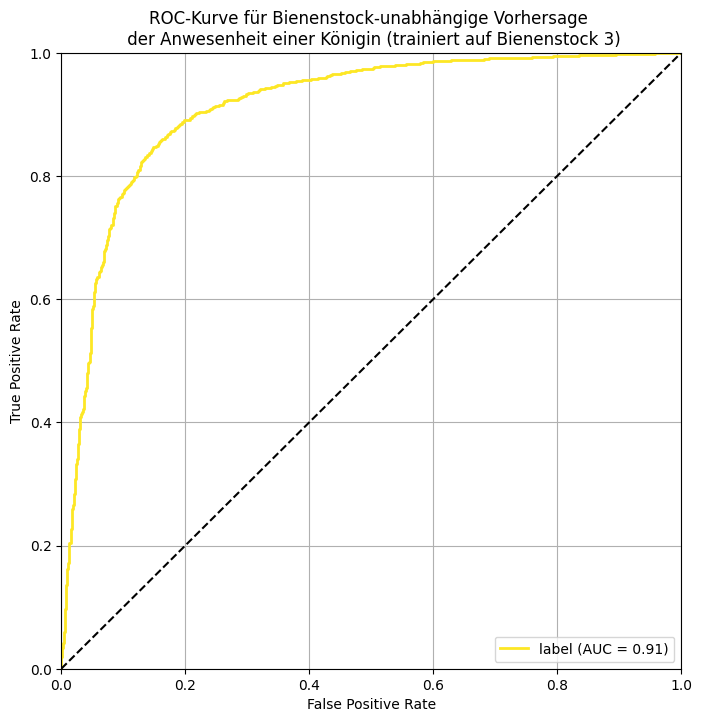

In [27]:
model_evaluation.plot_roc_curves(labels_test_array, predictions_test_array, classes=["label"], title="ROC-Kurve für Bienenstock-unabhängige Vorhersage \n der Anwesenheit einer Königin (trainiert auf Bienenstock 3)")

# Transfer learning model (trained on all data)

In [22]:
trainer_yamnet = Train(YamnetTransferModel(), nn.BCELoss(), dataset="WAV")

Layer (type:depth-idx)                   Param #
YamnetTransferModel                      --
├─Sequential: 1-1                        --
│    └─Linear: 2-1                       524,800
│    └─ReLU: 2-2                         --
│    └─Linear: 2-3                       513
Total params: 525,313
Trainable params: 525,313
Non-trainable params: 0


In [24]:
model_name = 'model_20240924_162931_14'

checkpoint_path = '../models/final/' + model_name + '_checkpoint.pt'
model = YamnetTransferModel()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
model_loaded, optimizer, start_epoch, train_samples, val_samples, test_samples = trainer_yamnet.load_model(checkpoint_path, model, optimizer)
model = model_loaded

In [25]:
model.eval()

labels_test = []
predictions_test = []

with torch.no_grad():
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Evaluation will happen on {device}.")
    model.to(device)

    for vdata in tqdm(trainer_yamnet.test_dataloader):
        vinputs, vlabels = vdata
        vinputs, vlabels = vinputs.to(device), vlabels.to(device)
        voutputs = model(vinputs)
        labels_test.extend(vlabels)
        predictions_test.extend(voutputs)

labels_test = torch.stack(labels_test)
predictions_test = torch.stack(predictions_test)

print(labels_test.shape)

Evaluation will happen on cpu.


100%|██████████| 27/27 [10:14<00:00, 22.75s/it]

torch.Size([860])


### Plot confusion matrix

<Axes: title={'center': 'Confusion Matrix: Trainiertes Transfer Learning Modell (auf allen Daten)'}, xlabel='Predicted', ylabel='Actual'>

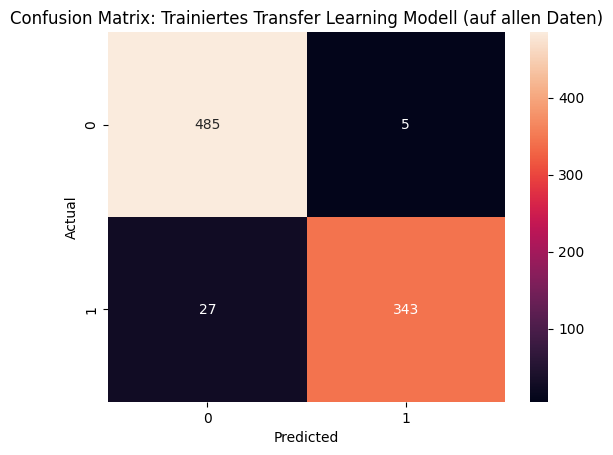

In [26]:
conf_matr = confusion_matrix(labels_test.cpu().numpy(), predictions_test.cpu().numpy().squeeze().round())
plt = sb.heatmap(conf_matr, annot=True, fmt='d')
plt.set_xlabel("Predicted")
plt.set_ylabel("Actual")
plt.set_title("Confusion Matrix: Trainiertes Transfer Learning Modell (auf allen Daten)")
plt

### Print classification report

In [27]:
print(classification_report(labels_test.cpu().numpy(), predictions_test.cpu().numpy().squeeze().round()))

              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97       490
         1.0       0.99      0.93      0.96       370

    accuracy                           0.96       860
   macro avg       0.97      0.96      0.96       860
weighted avg       0.96      0.96      0.96       860



### Plot ROC-Curve

In [28]:
predictions_test_array = predictions_test[:, np.newaxis]
labels_test_array = labels_test[:, np.newaxis]

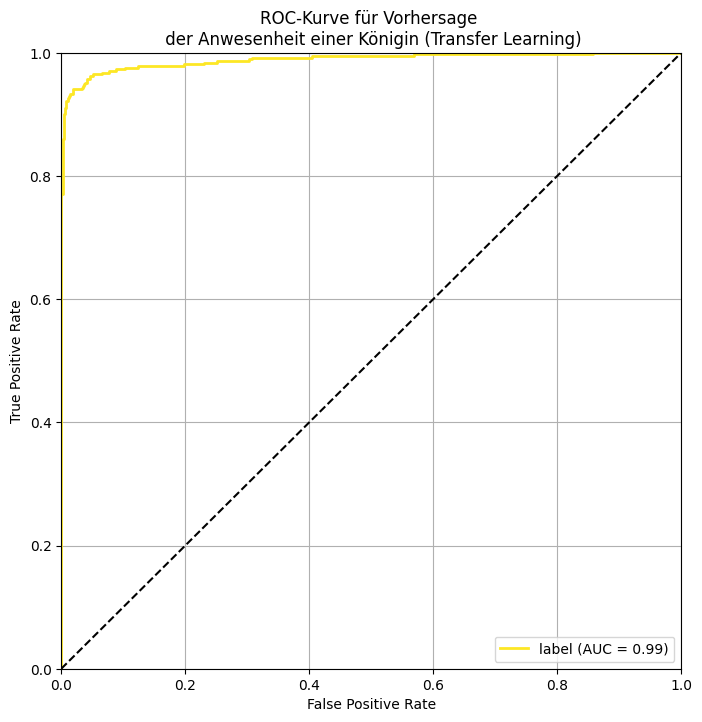

In [29]:
model_evaluation.plot_roc_curves(labels_test_array, predictions_test_array, classes=["label"], title="ROC-Kurve für Vorhersage \n der Anwesenheit einer Königin (Transfer Learning)")

## Evaluate CNN (trained on all datapoints) with deprecated dataset from [Kaggle](https://www.kaggle.com/datasets/annajyang/beehive-sounds)

In [ ]:
metadata = np.load(config.PROCESSED_METADATA_FILE_SEGMENTED, allow_pickle=True)

metadata_column_names = ['device', 'hive number', 'date', 'hive temp', 'hive humidity',
'hive pressure', 'weather temp', 'weather humidity', 'weather pressure',
'wind speed', 'gust speed', 'weatherID', 'cloud coverage', 'rain',
'lat', 'long', 'file name', 'queen presence', 'queen acceptance',
'frames', 'target', 'time', 'queen status']

metadata_df = pd.DataFrame(metadata, columns=metadata_column_names)
metadata_df.head()

,device,hive number,date,hive temp,hive humidity,hive pressure,weather temp,weather humidity,weather pressure,wind speed,...,rain,lat,long,file name,queen presence,queen acceptance,frames,target,time,queen status
0,2,3,2022-06-05 17:41:01,29.84,43.53,1007.27,24.15,68,1013,5.14,...,0,37.29,-121.95,2022-06-05--17-41-01_2__segment0.wav,1,2,10,5,0.708,0
1,2,3,2022-06-05 17:41:01,29.84,43.53,1007.27,24.15,68,1013,5.14,...,0,37.29,-121.95,2022-06-05--17-41-01_2__segment1.wav,1,2,10,5,0.708,0
2,2,3,2022-06-05 17:41:01,29.84,43.53,1007.27,24.15,68,1013,5.14,...,0,37.29,-121.95,2022-06-05--17-41-01_2__segment2.wav,1,2,10,5,0.708,0
3,2,3,2022-06-05 17:41:01,29.84,43.53,1007.27,24.15,68,1013,5.14,...,0,37.29,-121.95,2022-06-05--17-41-01_2__segment3.wav,1,2,10,5,0.708,0
4,2,3,2022-06-05 17:41:01,29.84,43.53,1007.27,24.15,68,1013,5.14,...,0,37.29,-121.95,2022-06-05--17-41-01_2__segment4.wav,1,2,10,5,0.708,0


In [ ]:
model_name = 'model_20240923_131940_19_all_data'

trainer_kaggle = TrainKaggle(CNNModel(), nn.BCELoss())
checkpoint_path = '../../models/final/' + model_name + '_checkpoint.pt'
model = CNNModel()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
model_loaded, optimizer, start_epoch, train_samples, val_samples, test_samples = trainer_kaggle.load_model(checkpoint_path, model, optimizer)
model = model_loaded

Layer (type:depth-idx)                   Param #
CNNModel                                 --
├─Conv2d: 1-1                            160
├─Conv2d: 1-2                            4,640
├─Conv2d: 1-3                            18,496
├─Conv2d: 1-4                            73,856
├─MaxPool2d: 1-5                         --
├─Flatten: 1-6                           --
├─Linear: 1-7                            1,130,560
├─Linear: 1-8                            65
Total params: 1,227,777
Trainable params: 1,227,777
Non-trainable params: 0


In [ ]:
model.eval()

labels_test = []
predictions_test = []

with torch.no_grad():
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Evaluation will happen on {device}.")
    model.to(device)

    for vdata in tqdm(trainer_kaggle.test_dataloader):
        vinputs, vlabels = vdata
        vinputs, vlabels = vinputs.to(device), vlabels.to(device)
        voutputs = model(vinputs)
        labels_test.extend(vlabels)
        predictions_test.extend(voutputs)

labels_test = torch.stack(labels_test)
predictions_test = torch.stack(predictions_test)

print(labels_test.shape)

Evaluation will happen on cpu.


100%|██████████| 222/222 [07:05<00:00,  1.92s/it]

torch.Size([7100])


### Plot confusion matrix

<Axes: xlabel='Predicted', ylabel='Actual'>

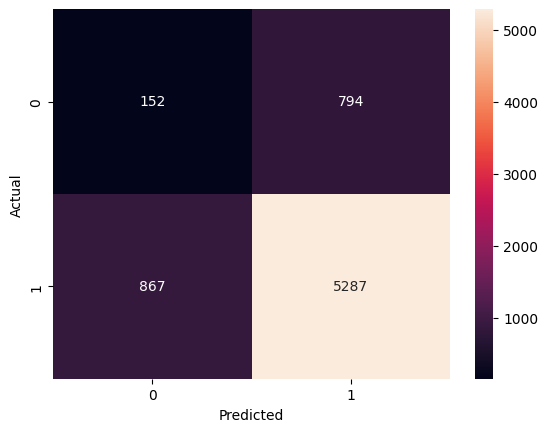

In [ ]:
conf_matr = confusion_matrix(labels_test.cpu().numpy(), predictions_test.cpu().numpy().squeeze().round())
plt = sb.heatmap(conf_matr, annot=True, fmt='d')
plt.set_xlabel("Predicted")
plt.set_ylabel("Actual")
plt

### Print classification report

In [ ]:
print(classification_report(labels_test.cpu().numpy(), predictions_test.cpu().numpy().squeeze().round()))

              precision    recall  f1-score   support

         0.0       0.15      0.16      0.15       946
         1.0       0.87      0.86      0.86      6154

    accuracy                           0.77      7100
   macro avg       0.51      0.51      0.51      7100
weighted avg       0.77      0.77      0.77      7100



### Plot ROC-Curve

In [ ]:
predictions_test_array = predictions_test[:, np.newaxis]
labels_test_array = labels_test[:, np.newaxis]

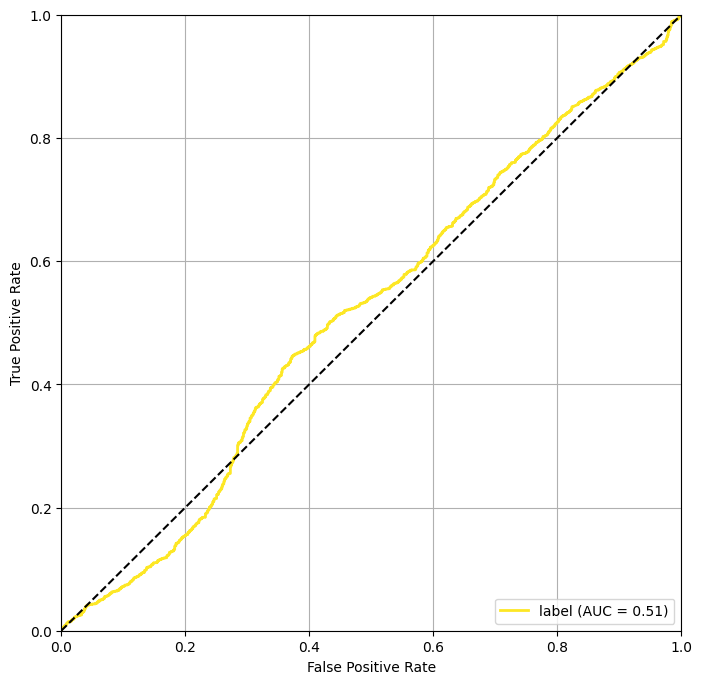

In [ ]:
model_evaluation.plot_roc_curves(labels_test_array, predictions_test_array, classes=["label"], title="")